# Figure 2. High-resolution mapping of TDP-43 dependent alternative polyadenylation using 3’ end-seq

## Load libraries and functions

In [1]:
shhh <- suppressPackageStartupMessages
shhh(library(data.table))
shhh(library(stringr))
shhh(library(ggplot2))
shhh(library("GenomicRanges"))
library("viridis") 
library(patchwork)
library(ggrastr)
library(ggridges)
shhh(library(BSgenome.Hsapiens.UCSC.hg38))
Hs=BSgenome.Hsapiens.UCSC.hg38

Loading required package: viridisLite



In [2]:
library(tidyplots)

In [3]:
library('Cairo')
CairoFonts(
regular="Sans:style=Light",
bold="Sans:style=Bold",
italic="Sans:style=Oblique",
bolditalic="Sans:style=BoldOblique"
)
options(repr.plot.width=12, repr.plot.height=8)

## Fig. S2a, polyA signal frequency plot

In [4]:
pas_2.75_f = fread("Fig_s2a-c_polyA_clusters_w_3UTRext_filtered.csv")

In [77]:
make_polyA_signal_freq_plot = function(dt){
    ddt = copy(dt)
    ddt$motif = factor(ddt$motif, levels = names(sort(-table(dt[annotated == "yes", motif]))))
    ddt[, polyA_signal := "APA"]
    ddt[motif == "AATAAA", polyA_signal := "AATAAA"]
    ddt[motif == "ATTAAA", polyA_signal := "ATTAAA"]
    ddt$polyA_signal = factor(ddt$polyA_signal, levels = c("AATAAA", "ATTAAA", "APA"))
    freq = ddt[, .(count = .N) ,by = .(motif, annotated)]
    freq[, frac := count/sum(count), by = annotated]
    freq = freq[order(frac)]
    freq$annotated = factor(freq$annotated, levels = c("yes", "no"))
    ggplot(freq, aes(motif, frac, fill = annotated)) + 
        geom_bar(stat = "identity", position = "dodge2") +
        scale_x_discrete(name = "polyA motif") +
        scale_y_continuous(name = "Fraction") +
        theme_classic(base_size = 6) + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
              legend.position = c(0.8, 0.6), 
          legend.title = element_text(size = 5), 
          legend.text = element_text(size = 5), 
          legend.key.width = unit(0.1, "in"), 
          legend.key.size = unit(0.01, "in")) + 
    scale_fill_viridis(discrete = T, option = "D", labels = c("Annotated", "Novel"))
}

In [78]:
polyA_signal_freq_plot = make_polyA_signal_freq_plot(pas_2.75_f)

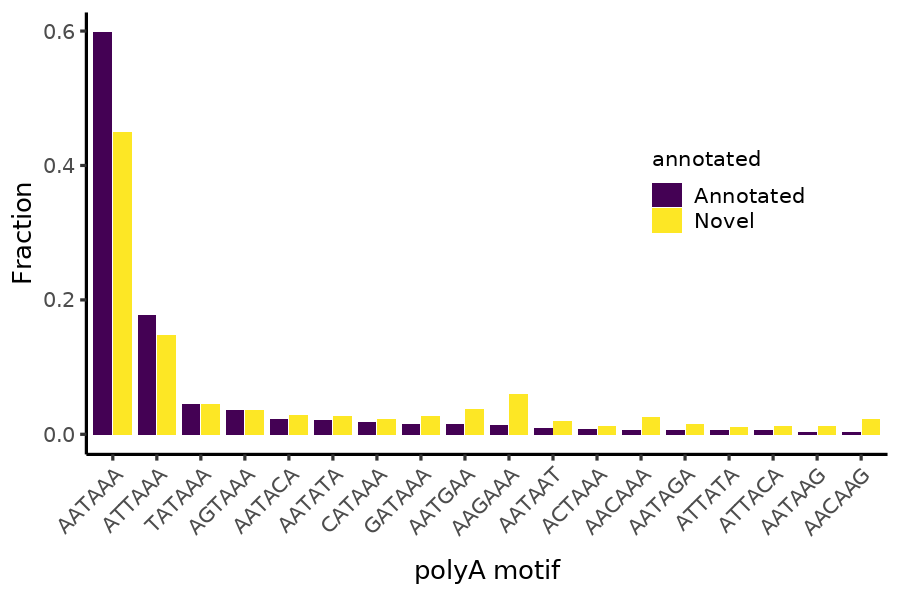

In [79]:
options(repr.plot.width=3, repr.plot.height=2, repr.plot.res = 300, repr.plot.units = "in")
polyA_signal_freq_plot

## Fig. S2b, polyA signal to cleavage site distrance distribution

In [83]:
make_polyA_signal_distance_plot = function(dt){
    ddt = copy(dt)
    ddt$motif = factor(ddt$motif, levels = names(sort(-table(dt[annotated == "yes", motif]))))
    ddt[, polyA_signal := "APA"]
    ddt[motif == "AATAAA", polyA_signal := "AATAAA"]
    ddt[motif == "ATTAAA", polyA_signal := "ATTAAA"]
    ddt$polyA_signal = factor(ddt$polyA_signal, levels = c("AATAAA", "ATTAAA", "APA"))
    ddt[, signal_site := tstrsplit(signal, "@", keep = 1, type.convert = T)]
    ddt[, dist := abs(signal_site - polyA_site)]
    ddt$annotated = factor(ddt$annotated, levels = c("yes", "no"))
    #freq = ddt[, .(count = .N) ,by = .(motif, annotated)]
    #freq[, frac := count/sum(count), by = annotated]
    #freq = freq[order(frac)]
    ggplot(ddt[dist > 5], aes(dist, fill = polyA_signal)) + 
        geom_histogram(bins = 55) +
        scale_x_continuous(name = "Distance of polyA signal to polyA site (nt)") +
        scale_y_continuous(name = "Counts") +
        facet_wrap(.~annotated, ncol = 1, nrow = 2, scales = "free_y", 
                   labeller = as_labeller(c("yes" = "Annotated polyA site", "no" = "Novel polyA site"))) +
        theme_classic(base_size = 6) + 
        theme(legend.position = c(0.8, 0.8), 
              legend.title = element_text(size = 5), 
              legend.text = element_text(size = 5), 
              legend.key.width = unit(0.05, "in"), 
              legend.key.size = unit(0.05, "in"),
              legend.background = element_blank(),
              strip.background = element_blank(), 
              #panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.background = element_blank()) + 
        scale_fill_viridis(discrete = T, option = "D")
}

In [84]:
polyA_signal_distance_plot = make_polyA_signal_distance_plot(pas_2.75_f[, .(chr, strand, polyA_site, signal, motif, annotated)])

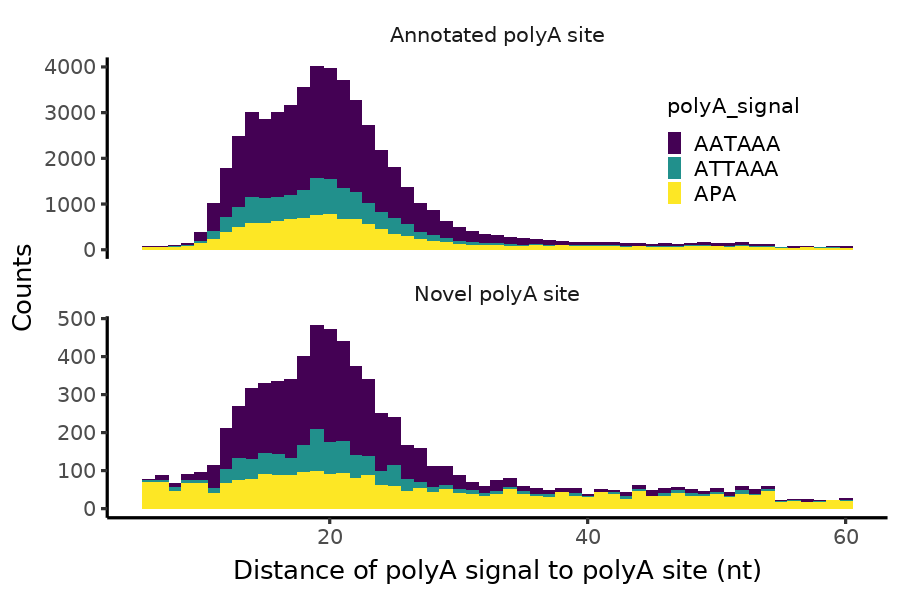

In [85]:
polyA_signal_distance_plot

## Fig. S2c, polyA site location

In [87]:
pas_2.75_anno_by_feature = pas_2.75_f[, .N, by = .(annotated, Feature)]

In [88]:
pas_2.75_anno_by_feature$annotated = factor(pas_2.75_anno_by_feature$annotated, levels = c("yes", "no"))

In [94]:
options(repr.plot.width=6, repr.plot.height=7)
pas_distribution_plot = ggplot(pas_2.75_anno_by_feature, aes(annotated, N, fill = Feature)) + 
    geom_bar(position="fill", stat="identity") + 
    scale_x_discrete(label = c("Annotated", "Novel"), name = "PolyA site") +
    scale_y_continuous(name = "Fraction") +
    scale_fill_viridis(discrete = T, option = "D") +
    theme_classic(base_size = 6) +
    theme(legend.title = element_text(size = 5), 
          legend.text = element_text(size = 5), 
          legend.key.width = unit(0.05, "in"), 
          legend.key.size = unit(0.05, "in"),
          legend.background = element_blank())

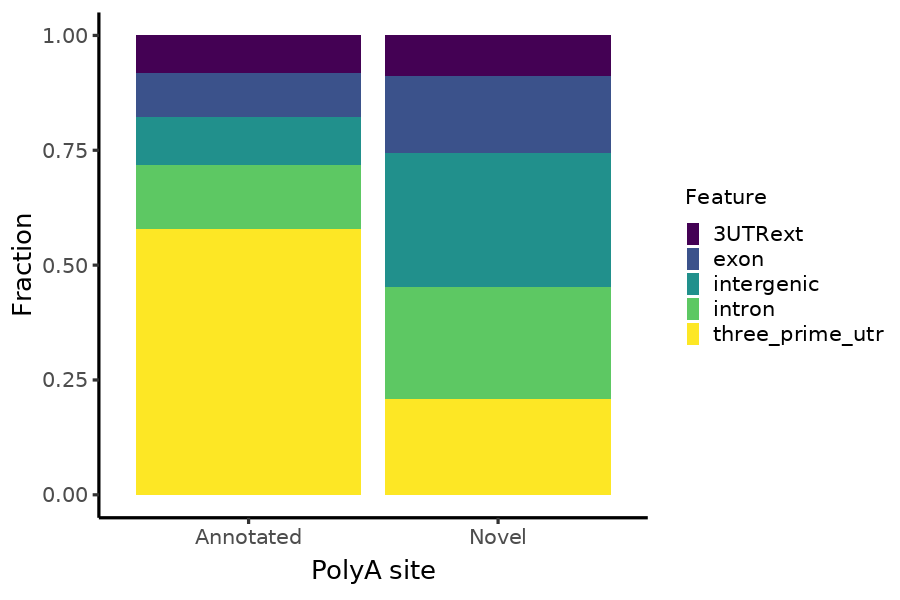

In [95]:
options(repr.plot.width=3, repr.plot.height=2, repr.plot.res = 300, repr.plot.units = "in")

pas_distribution_plot

In [99]:
fig_S2a_c = polyA_signal_freq_plot + polyA_signal_distance_plot + pas_distribution_plot + plot_layout(widths = unit(c(2,2,1), c("in","in","in")))

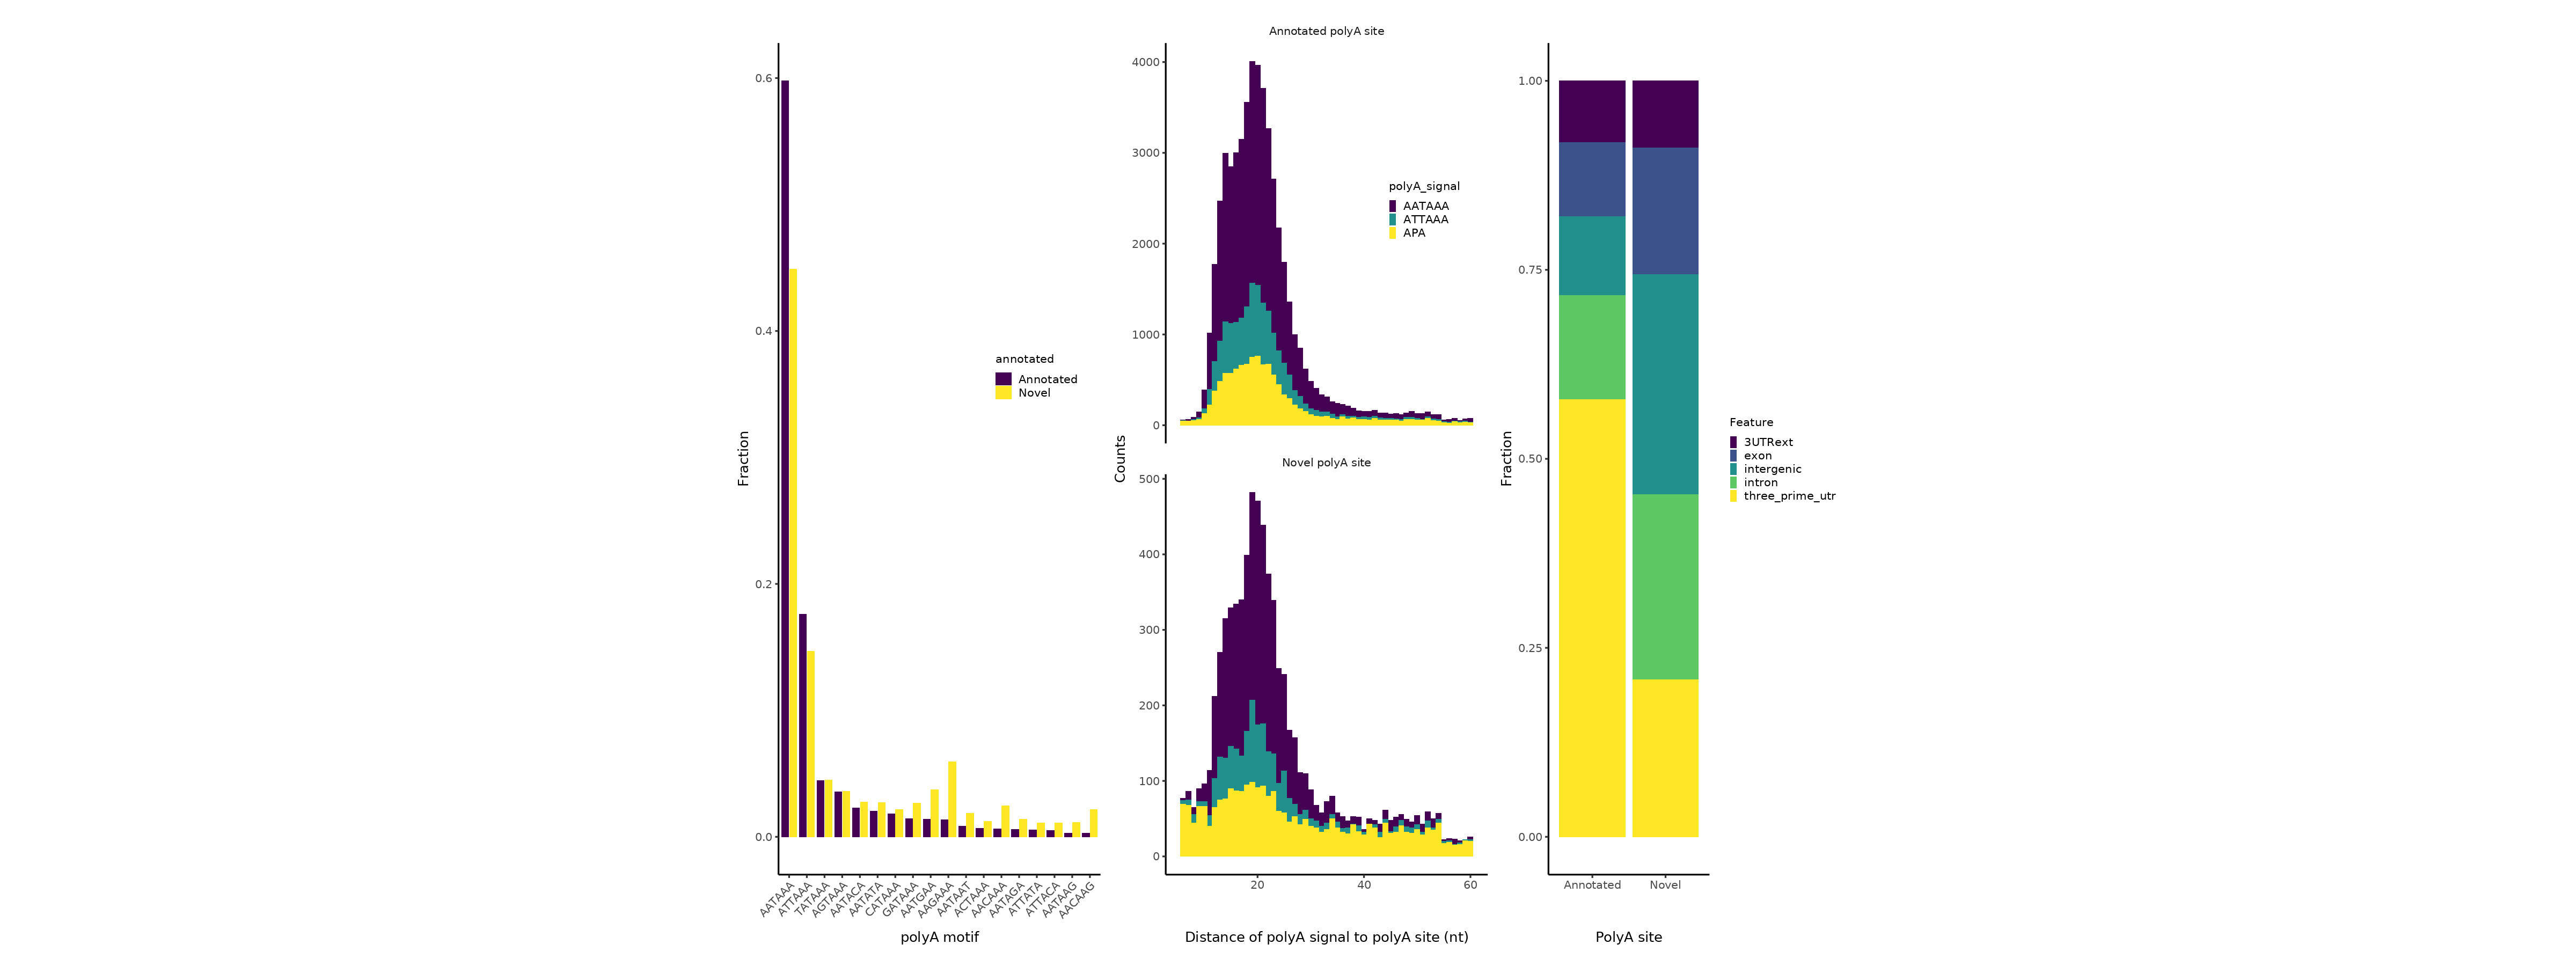

In [100]:
options(repr.plot.width=16, repr.plot.height=6)
fig_S2a_c 

In [101]:
ggsave(fig_S2a_c, filename = "fig_s2a-c_plots.pdf", width = 7, height = 2, units = "in")

## Fig. S2d-j, made in IGV

## Fig. S2k

In [102]:
arhgap32_ce = fread("Fig_s2k_TDP-437D-KD_ARHGAP32-CE_qRT-PCR-quantitation.csv")

✔ save_plot: saved to fig_s2k_TDP43-7D-KD-ARHGAP32-CE-qRT-PCR-plot.pdf



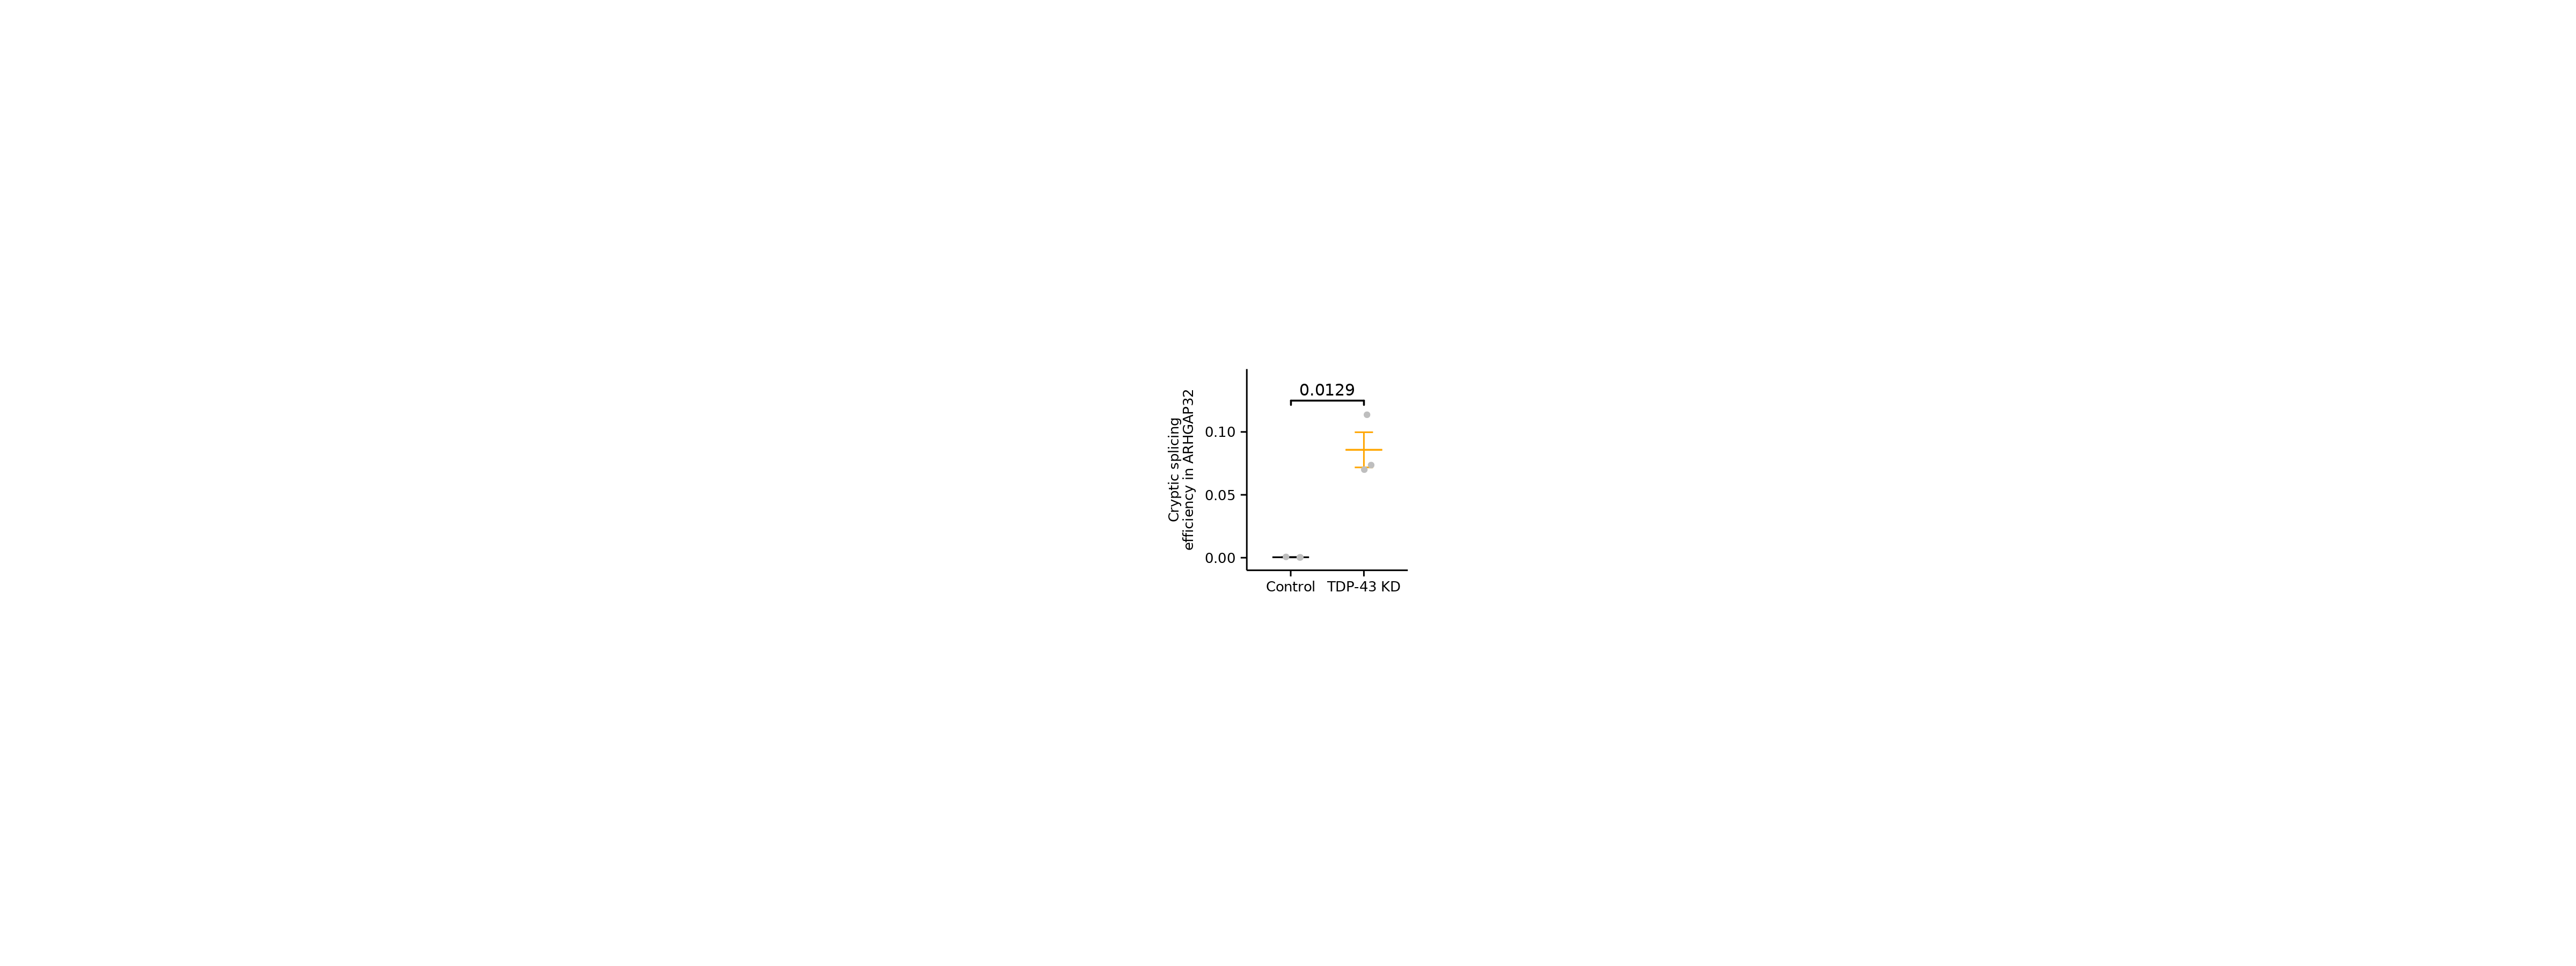

In [103]:
arhgap32_ce |>
    tidyplot(x = Sample, y = normalized_ratio, color = Sample) |>
    add_mean_dash(width = 0.5) |>
    add_sem_errorbar(width = 0.25) |>
    add_data_points_jitter(jitter_width = 0.3, size = 0.5, color = "gray") |>
    add_test_pvalue(hide_info = TRUE, 
                    method = "t_test",
                    method.args = list(alternative = "less")) |>
    adjust_colors(new_colors = c("black", "orange")) |> 
    remove_x_axis_title() |>
    adjust_y_axis(title = "Cryptic splicing\nefficiency in ARHGAP32",
                  limits = c(-0.01, 0.15), breaks = c(0, 0.05, 0.1)) |>
    remove_legend() |>
    adjust_size(width = 1, height = 1.25, unit = "in") |>
    adjust_font(fontsize = 6) |>
    save_plot("fig_s2k_TDP43-7D-KD-ARHGAP32-CE-qRT-PCR-plot.pdf", 
              view_plot = TRUE,
              bg = "transparent",
              dpi = 300)

## Fig. S2l-n, made in IGV

## Figure S2o

In [104]:
## from "../analysis/Rev_4.2.3_TDP43-ref-vs-APA-v3.ipynb"
apa_tdp43_dist = fread("Fig_3a_3c_apa-to-tdp43-ref-distance.csv")

In [105]:
apa_tdp43_dist$delta_usage_bin = factor(apa_tdp43_dist$delta_usage_bin, levels = c("2_decrease", "1_increase"))

#### Breakdown of increased and decreased usages

In [106]:
apa_tdp43_dist_ds_in = apa_tdp43_dist[delta_usage_bin == "1_increase" & closest > 0]
apa_tdp43_dist_ds_de = apa_tdp43_dist[delta_usage_bin == "2_decrease" & closest > 0]

In [107]:
apa_tdp43_dist_ds_in[, GT_bin := dplyr::ntile(xlinksite_GT_content, 4)]
apa_tdp43_dist_ds_de[, GT_bin := dplyr::ntile(xlinksite_GT_content, 4)]

In [141]:
wilcox.test(apa_tdp43_dist_ds_in[GT_bin == "1", delta_usage], 
            apa_tdp43_dist_ds_in[GT_bin == "4", delta_usage], alternative = "greater")


	Wilcoxon rank sum test with continuity correction

data:  apa_tdp43_dist_ds_in[GT_bin == "1", delta_usage] and apa_tdp43_dist_ds_in[GT_bin == "4", delta_usage]
W = 4044, p-value = 0.03718
alternative hypothesis: true location shift is greater than 0


In [143]:
wilcox.test(apa_tdp43_dist_ds_de[GT_bin == "1", delta_usage], 
            apa_tdp43_dist_ds_de[GT_bin == "4", delta_usage], alternative = "less")


	Wilcoxon rank sum test with continuity correction

data:  apa_tdp43_dist_ds_de[GT_bin == "1", delta_usage] and apa_tdp43_dist_ds_de[GT_bin == "4", delta_usage]
W = 44703, p-value = 0.006836
alternative hypothesis: true location shift is less than 0


In [125]:
apa_ds_tdp43_gt_de_plot = ggplot(apa_tdp43_dist_ds_de[GT_bin %in% c(1, 4)], aes(delta_usage, color = factor(GT_bin))) + 
    stat_ecdf() + 
    scale_y_continuous(name = "Cumulative fraction") +
    theme_classic(base_size = 6) + 
    scale_color_manual(values = c("#662D91", "#a7a9ac"),
                       name = "GU content",
                       labels = c("Low (bottom 20%)", "High (top 20%)")) +
    theme(legend.position = c(0.4, 0.8),
          legend.title = element_text(size = 5), 
          legend.text = element_text(size = 5), 
          legend.key.width = unit(0.05, "in"), 
          legend.key.size = unit(0.05, "in"),
          legend.background = element_blank())

In [135]:
apa_ds_tdp43_gt_in_plot = ggplot(apa_tdp43_dist_ds_in[GT_bin %in% c(1, 4)], aes(delta_usage, color = factor(GT_bin))) + 
    stat_ecdf() + 
    scale_y_continuous(name = "Cumulative fraction") +
    theme_classic(base_size = 6) + 
    scale_color_manual(values = c("#662D91", "#a7a9ac"),
                       name = "GU content",
                       labels = c("Low (bottom 20%)", "High (top 20%)")) +
    theme(legend.position = c(0.55, 0.15),
          legend.title = element_text(size = 5), 
          legend.text = element_text(size = 5), 
          legend.key.width = unit(0.05, "in"), 
          legend.key.size = unit(0.05, "in"),
          legend.background = element_blank())

In [136]:
apa_ds_tdp43_gt_plot_combined = apa_ds_tdp43_gt_de_plot + apa_ds_tdp43_gt_in_plot

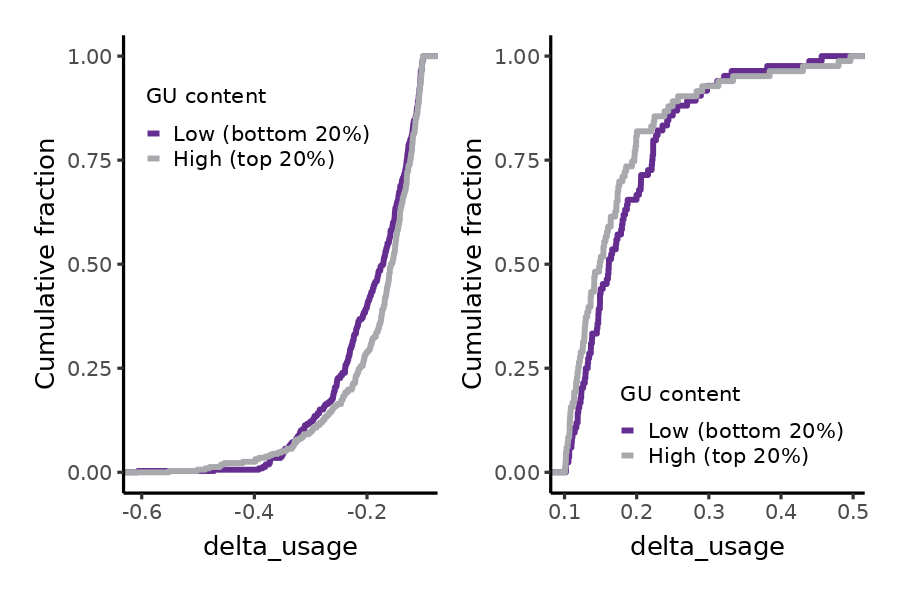

In [137]:
options(repr.plot.width=3, repr.plot.height=2, repr.plot.res = 300, repr.plot.units = "in")

apa_ds_tdp43_gt_plot_combined

In [145]:
ggsave(apa_ds_tdp43_gt_plot_combined, file = "fig_S2o_apa_ds_tdp43_gt_plot_combined.pdf", width = 3, height = 2.25, units = "in", dpi = 300)

In [146]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /share/software/user/open/openblas/0.3.10/lib/libopenblas_haswellp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Cairo_1.6-2                       tidyplots_0.2.2                  
 [3] BSgenome.Hsapiens.UCSC.hg38_1.4.5 BSgenome_1.66.3                  
 [5] rtracklayer_1.58.0                Biostrings_2.66.0                
 [7] XVector_0.38.0                    ggridges_0.5.6    